# Importing libraries.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import torch
from kan import KAN
from fastkan import FastKAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [81]:
use_cuda_if_available = False
device_name = "cuda" if torch.cuda.is_available() and use_cuda_if_available else "cpu"
DEVICE = torch.device("cuda" if torch.cuda.is_available() and use_cuda_if_available else "cpu")
DEVICE

device(type='cpu')

# Creating class of dataset of images

In [82]:
class ImgDataset(Dataset):
    def __init__(self, imagesPath, labels, img_size=(32, 32)):
        super().__init__()
        self.imagesPath = imagesPath
        self.labels = labels
        self.img_size = img_size

    def __len__(self):
        return len(self.imagesPath)
    
    def __getitem__(self, index):
        imagePath = self.imagesPath[index]

        img = Image.open(imagePath).convert('RGB')
        img = img.resize(self.img_size)

        img_array = np.array(img) / 255.0

        flattened_img = img_array.flatten()

        img_tensor = torch.FloatTensor(flattened_img)
        label_tensor = torch.LongTensor([self.labels[index]]).squeeze()

        return img_tensor, label_tensor

# Load paths of images and their labels

In [83]:
trainCsvPath = "data/trainLabels.csv"
trainImagesPath = "data/train"

df = pd.read_csv(trainCsvPath)

imgs_paths = []
labels = []

for index, row in df.iterrows():
    img_path = os.path.join(trainImagesPath, f"{row['id_code']}.jpg")

    if os.path.exists(img_path):
        imgs_paths.append(img_path)
        labels.append(row['diagnosis'])
    else:
        print(f"File with path {img_path} not found")

print(f"Successfully loaded {len(imgs_paths)}/{len(df)} images.")

Successfully loaded 3662/3662 images.


# Creating datasets for train and validation data

In [84]:
train_paths, val_paths, train_labels, val_labels = train_test_split(imgs_paths, labels, test_size=0.2, random_state=42, stratify=labels)

img_size = (16, 16)
batches_size = 1024

train_dataset = ImgDataset(train_paths, train_labels, img_size)
val_dataset = ImgDataset(val_paths, val_labels, img_size)

train_loader = DataLoader(train_dataset, batch_size=batches_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batches_size, shuffle=False, num_workers=0)

# Create and train model

In [85]:
class MyKan(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[32], grid=3, k=2, device='cpu', use_fastkan=False):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim

        layers = [input_dim] + hidden_dims + [output_dim]

        if use_fastkan:
            self.kan = FastKAN(layers_hidden=layers, grid_max=3)
        else:
            self.kan = KAN(width=layers, grid=grid, k=k, seed=42, save_act=False, auto_save=False, device=device)

    def forward(self, x):
        return self.kan(x)
    
    def plot(self, *args, **kwargs):
        return self.kan.plot(*args, **kwargs)

In [86]:
input_dim = img_size[0] * img_size[1] * 3
output_dim = 5

print(input_dim)

model = MyKan(input_dim, output_dim, hidden_dims=[32, 16], device=device_name, use_fastkan=True)

model = model.to(DEVICE)

print(model)
print(sum(p.numel() for p in model.parameters()))

768
MyKan(
  (kan): FastKAN(
    (layers): ModuleList(
      (0): FastKANLayer(
        (layernorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=6144, out_features=32, bias=False)
        (base_linear): Linear(in_features=768, out_features=32, bias=True)
      )
      (1): FastKANLayer(
        (layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=256, out_features=16, bias=False)
        (base_linear): Linear(in_features=32, out_features=16, bias=True)
      )
      (2): FastKANLayer(
        (layernorm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
        (rbf): RadialBasisFunction()
        (spline_linear): SplineLinear(in_features=128, out_features=5, bias=False)
        (base_linear): Linear(in_features=16, out_features=5, bias=True)
      )
    )
  )
)
228221


In [89]:
def train_model_with_valid(model, train_loader, val_loader, lr=1e-5, epochs=300, print_every_step=5, early_stopping=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.CrossEntropyLoss().to(DEVICE)
    
    last_val_loss = 999999.0

    print("Training...")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for index, (images, labels) in enumerate(train_loader):
            if use_cuda_if_available:
                images = images.to(DEVICE)
                labels = labels.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(images) 
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if index % print_every_step == 0 or index == len(train_loader):
                print(f"Epoch: {epoch}; step: {index}/{len(train_loader)}; loss: {loss.item():.4f}")

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct / total

        model.eval()

        val_loss = 0.0
        val_correct = 0.0
        val_total = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                if use_cuda_if_available:
                    images = images.to(DEVICE)
                    labels = labels.to(DEVICE)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total

        print(f"Epoch {epoch}:\n Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%; Val Loss {epoch_val_loss:.4f}, Val Acc {epoch_val_acc:.2f}%")

In [90]:
train_model_with_valid(model, train_loader, val_loader)

Training...
Epoch: 0; step: 0/3; loss: 1.3160
Epoch 0:
 Train Loss: 1.3150, Train Acc: 58.28%; Val Loss 1.3044, Val Acc 58.25%
Epoch: 1; step: 0/3; loss: 1.3008
Epoch 1:
 Train Loss: 1.3104, Train Acc: 58.93%; Val Loss 1.2993, Val Acc 58.39%
Epoch: 2; step: 0/3; loss: 1.3388
Epoch 2:
 Train Loss: 1.3052, Train Acc: 59.44%; Val Loss 1.2944, Val Acc 58.80%
Epoch: 3; step: 0/3; loss: 1.2947
Epoch 3:
 Train Loss: 1.3013, Train Acc: 59.75%; Val Loss 1.2896, Val Acc 59.48%
Epoch: 4; step: 0/3; loss: 1.2987
Epoch 4:
 Train Loss: 1.2965, Train Acc: 59.82%; Val Loss 1.2850, Val Acc 60.16%
Epoch: 5; step: 0/3; loss: 1.3056
Epoch 5:
 Train Loss: 1.2910, Train Acc: 60.12%; Val Loss 1.2805, Val Acc 60.57%
Epoch: 6; step: 0/3; loss: 1.2774
Epoch 6:
 Train Loss: 1.2879, Train Acc: 60.57%; Val Loss 1.2761, Val Acc 61.26%
Epoch: 7; step: 0/3; loss: 1.2740
Epoch 7:
 Train Loss: 1.2828, Train Acc: 60.91%; Val Loss 1.2717, Val Acc 61.94%
Epoch: 8; step: 0/3; loss: 1.2894
Epoch 8:
 Train Loss: 1.2778, Trai

# Validate model.

Averaage loss: 0.8746 Val accuracy: 70.12%
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       361
           1       0.00      0.00      0.00        74
           2       0.51      0.86      0.64       200
           3       0.00      0.00      0.00        39
           4       1.00      0.02      0.03        59

    accuracy                           0.70       733
   macro avg       0.47      0.36      0.32       733
weighted avg       0.64      0.70      0.62       733



c:\Users\rost1\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rost1\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\rost1\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

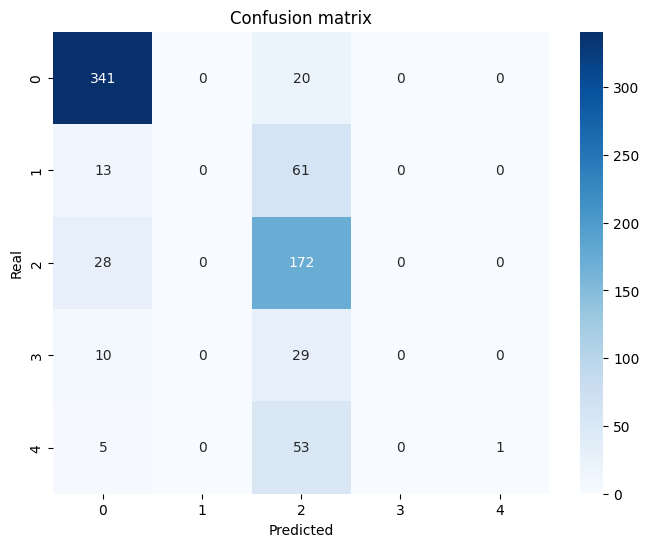

In [91]:
with torch.no_grad():
    model.eval()

    criterion = torch.nn.CrossEntropyLoss()
    
    val_loss = 0.0
    all_preds = []
    all_labels = []
    for images, labels in val_loader:
        if use_cuda_if_available:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
    
        outputs = model(images)

        loss = criterion(outputs, labels)
        val_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    avg_loss = val_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)

    report = classification_report(all_labels, all_preds)

    confMatrix = confusion_matrix(all_labels, all_preds)

    print(f"Averaage loss: {avg_loss:.4f} Val accuracy: {accuracy*100:.2f}%")
    print(report)

    plt.figure(figsize=(8, 6))
    sns.heatmap(confMatrix, annot=True, fmt='d', cmap='Blues')
    plt.title("Confusion matrix")
    plt.ylabel("Real")
    plt.xlabel("Predicted")
    plt.show()